In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

from copy import deepcopy
from IPython.display import Audio
from module import models_lib
from module import config_lib, utils_lib


import librosa
import noisereduce as nr
import soundfile as sf
from IPython.display import Audio

In [2]:

class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = "/kaggle/input/bc25-models-fold0-mel-0411"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            self.model_path =  "../models/mel_cleaned0413/"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 64
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        


        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            
    
            
cfg = CFG(mode="inference", kaggle_notebook=False, debug=False)




In [3]:

utils_lib.set_seed(cfg.seed)

In [4]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [5]:
train_label.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [6]:
taxonomy.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [7]:
file_path = "../models/tuning_0522/models_20250522_0100/"
hypara = pd.read_csv(file_path + "config.csv")
log = pd.read_csv(file_path + "log_fold0.csv")

In [8]:
search_space_keys = ['lr', 'mixup_alpha', 'mixup_prob', 'weight_decay']

import os
import pandas as pd
from tqdm import tqdm

search_space_keys = ['lr', 'mixup_alpha', 'mixup_prob', 'weight_decay']

def summarize_training_result(file_path: str) -> pd.DataFrame:
    try:
        config = pd.read_csv(os.path.join(file_path, "config.csv"))
        log = pd.read_csv(os.path.join(file_path, "log_fold0.csv")).drop(columns=["lr"], errors='ignore')

        config_df = config.set_index("key").T
        selected_keys = [key for key in search_space_keys if key in config_df.columns]
        config_df = config_df[selected_keys]
        config_df.reset_index(drop=True, inplace=True)

        config_broadcasted = pd.concat([config_df] * len(log), ignore_index=True)
        config_broadcasted["filepath"] = file_path

        summary_df = pd.concat([log, config_broadcasted], axis=1)
        return summary_df

    except Exception as e:
        print(f"スキップ: {file_path} にてエラー: {e}")
        return pd.DataFrame()

def summarize_all_results(root_path: str) -> pd.DataFrame:
    all_summaries = []

    for subdir in tqdm(os.listdir(root_path)):
        full_path = os.path.join(root_path, subdir)

        # debugディレクトリを除外
        if os.path.isdir(full_path) and "debug" not in subdir.lower():
            summary_df = summarize_training_result(full_path + "/")
            if not summary_df.empty:
                all_summaries.append(summary_df)

    if all_summaries:
        return pd.concat(all_summaries, ignore_index=True)
    else:
        return pd.DataFrame()

# 実行
root_path = "../models/tuning_0522/"
all_summary_df = summarize_all_results(root_path)

def add_best_val_auc_column(df: pd.DataFrame) -> pd.DataFrame:
    # 各filepathごとの最大val_aucを求める
    best_val_auc_map = df.groupby("filepath")["val_auc"].max().to_dict()

    # 新しい列を作って、各行にそのfilepathの最大val_aucを追加
    df["best_val_auc"] = df["filepath"].map(best_val_auc_map)

    return df

def extract_best_hyperparams(df: pd.DataFrame) -> pd.DataFrame:
    # filepath ごとに val_auc が最大の行を取得
    idx = df.groupby("filepath")["val_auc"].idxmax()
    best_rows = df.loc[idx].copy()

    # 必要なハイパラ＋評価スコアのみ抽出
    best_hypara_df = best_rows[[
        'filepath', 'val_auc', 'val_map',
        'lr', 'mixup_alpha', 'mixup_prob', 'weight_decay'
    ]].sort_values(by="val_auc", ascending=False).reset_index(drop=True)

    return best_hypara_df

# 実行


# 適用
all_summary_df = add_best_val_auc_column(all_summary_df)
best_hypara_df = extract_best_hyperparams(all_summary_df)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 249.00it/s]


In [11]:
best_hypara_df

,filepath,val_auc,val_map,lr,mixup_alpha,mixup_prob,weight_decay
0,../models/tuning_0522/models_20250522_0450/,0.964192,0.618321,0.0005,0.2,0.7,0.0
1,../models/tuning_0522/models_20250522_0506/,0.964192,0.618321,0.0005,0.2,0.7,1e-05
2,../models/tuning_0522/models_20250522_1000/,0.964037,0.640209,0.001,0.4,0.7,0.0001
3,../models/tuning_0522/models_20250522_0552/,0.963795,0.622629,0.0005,0.4,0.3,1e-05
4,../models/tuning_0522/models_20250522_0536/,0.963795,0.622629,0.0005,0.4,0.3,0.0
5,../models/tuning_0522/models_20250522_0724/,0.963597,0.633886,0.001,0.2,0.3,1e-05
6,../models/tuning_0522/models_20250522_0709/,0.963597,0.633886,0.001,0.2,0.3,0.0
7,../models/tuning_0522/models_20250522_0739/,0.963576,0.660614,0.001,0.2,0.3,0.0001
8,../models/tuning_0522/models_20250522_0521/,0.962915,0.618867,0.0005,0.2,0.7,0.0001
9,../models/tuning_0522/models_20250522_0607/,0.962621,0.610431,0.0005,0.4,0.3,0.0001


In [19]:

import os
model_dir = "../models/tuning_0522/models_20250522_0506/"

# スコア格納辞書（foldごとの記録）
score_lists = {
    'val_auc': [],
    'train_auc': [],
    'val_map': [],
    'train_map': [],
    'val_loss': [],
    'train_loss': [],
    'epoch': [],
}

# 各foldのベストスコア収集
for fold in range(5):
    log_path = os.path.join(model_dir, f"log_fold{fold}.csv")
    if not os.path.exists(log_path):
        print(f"Missing log for fold {fold}: {log_path}")
        continue

    df = pd.read_csv(log_path)
    best_row = df.loc[df['val_auc'].idxmax()]

    print(f"Fold {fold} best epoch: {int(best_row['epoch'])}, val_auc: {best_row['val_auc']:.3f}, train_auc: {best_row['train_auc']:.3f}")

    for key in score_lists:
        score_lists[key].append(best_row[key])

# 平均スコアを整形（.3fで表示、epochだけ.2f）
score_means = {}
for key, values in score_lists.items():
    avg = sum(values) / len(values)
    display_key = f"Avg {key.replace('_', ' ').title()}"
    if "epoch" in key:
        score_means[display_key] = f"{avg:.2f}"
    else:
        score_means[display_key] = f"{avg:.3f}"

# config.csv 読み込み
config_path = os.path.join(model_dir, "config.csv")
config_df = pd.read_csv(config_path)

important_keys = [
    'model_name','batch_size', 'epochs',
    'optimizer', 'lr', 'weight_decay', 'scheduler', 'min_lr', "tta",
]

# config情報の統合
config_dict = {"Note": "", "LB AUC": "", **score_means }
for key in important_keys:
    value = config_df.loc[config_df['key'] == key, 'value'].values
    config_dict[key] = value[0] if len(value) > 0 else ""

# Markdown出力
all_keys = list(config_dict.keys())
print("\n```markdown")
print("| " + " | ".join(all_keys) + " |")
print("|" + "|".join(["-" * (len(k)+2) for k in all_keys]) + "|")
print("| " + " | ".join(str(config_dict[k]) for k in all_keys) + " |")
print("```")
df

Fold 0 best epoch: 10, val_auc: 0.964, train_auc: 0.991
Missing log for fold 1: ../models/tuning_0522/models_20250522_0506/log_fold1.csv
Missing log for fold 2: ../models/tuning_0522/models_20250522_0506/log_fold2.csv
Missing log for fold 3: ../models/tuning_0522/models_20250522_0506/log_fold3.csv
Missing log for fold 4: ../models/tuning_0522/models_20250522_0506/log_fold4.csv

```markdown
| Note | LB AUC | Avg Val Auc | Avg Train Auc | Avg Val Map | Avg Train Map | Avg Val Loss | Avg Train Loss | Avg Epoch | model_name | batch_size | epochs | optimizer | lr | weight_decay | scheduler | min_lr | tta |
|------|--------|-------------|---------------|-------------|---------------|--------------|----------------|-----------|------------|------------|--------|-----------|----|--------------|-----------|--------|-----|
|  |  | 0.964 | 0.991 | 0.618 | 0.749 | 0.012 | 0.010 | 10.00 | efficientnet_b0 | 32 | 10 | AdamW | 0.0005 | 1e-05 | CosineAnnealingLR | 1e-06 |  |
```


,epoch,lr,epoch_time_min,train_loss,train_auc,train_map,val_loss,val_auc,val_map
0,1,0.000488,1.53,0.036561,0.595410,0.012098,0.024780,0.812979,0.108515
1,2,0.000452,1.54,0.023061,0.840423,0.117577,0.018723,0.914944,0.301330
2,3,0.000397,1.54,0.019015,0.907975,0.249669,0.016173,0.940804,0.420171
3,4,0.000328,1.54,0.016666,0.948137,0.352454,0.014527,0.948355,0.498716
4,5,0.000251,1.54,0.014790,0.960934,0.440862,0.013669,0.953823,0.545141
5,6,0.000173,1.54,0.013384,0.971981,0.537195,0.013268,0.956595,0.575345
6,7,0.000104,1.53,0.011962,0.981643,0.626517,0.012840,0.962037,0.587597
7,8,0.000049,1.53,0.010990,0.985091,0.684876,0.012744,0.962444,0.604680
8,9,0.000013,1.53,0.010269,0.987425,0.739064,0.012579,0.964034,0.610180
9,10,0.000001,1.52,0.009872,0.990754,0.749427,0.012487,0.964192,0.618321


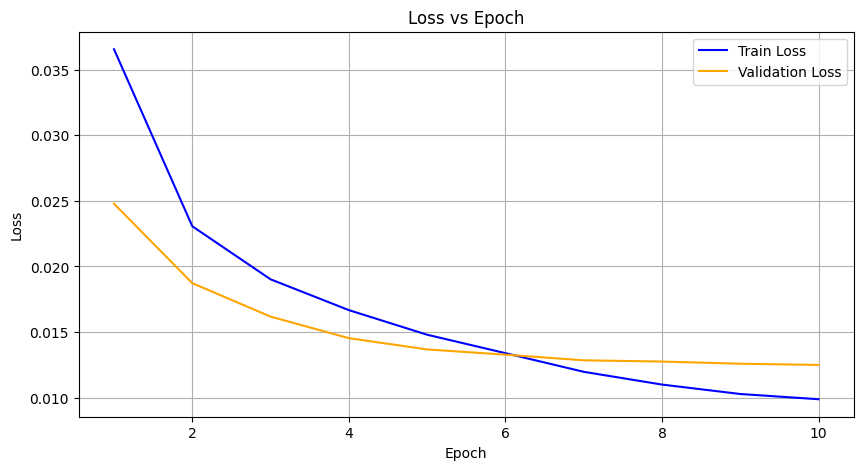

In [20]:
model_dir_name = "../models/tuning_0522/models_20250522_0506/"
i = 0
log_path = os.path.join(model_dir, f"log_fold{i}.csv")

# lossをプロット
df = pd.read_csv(log_path)
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

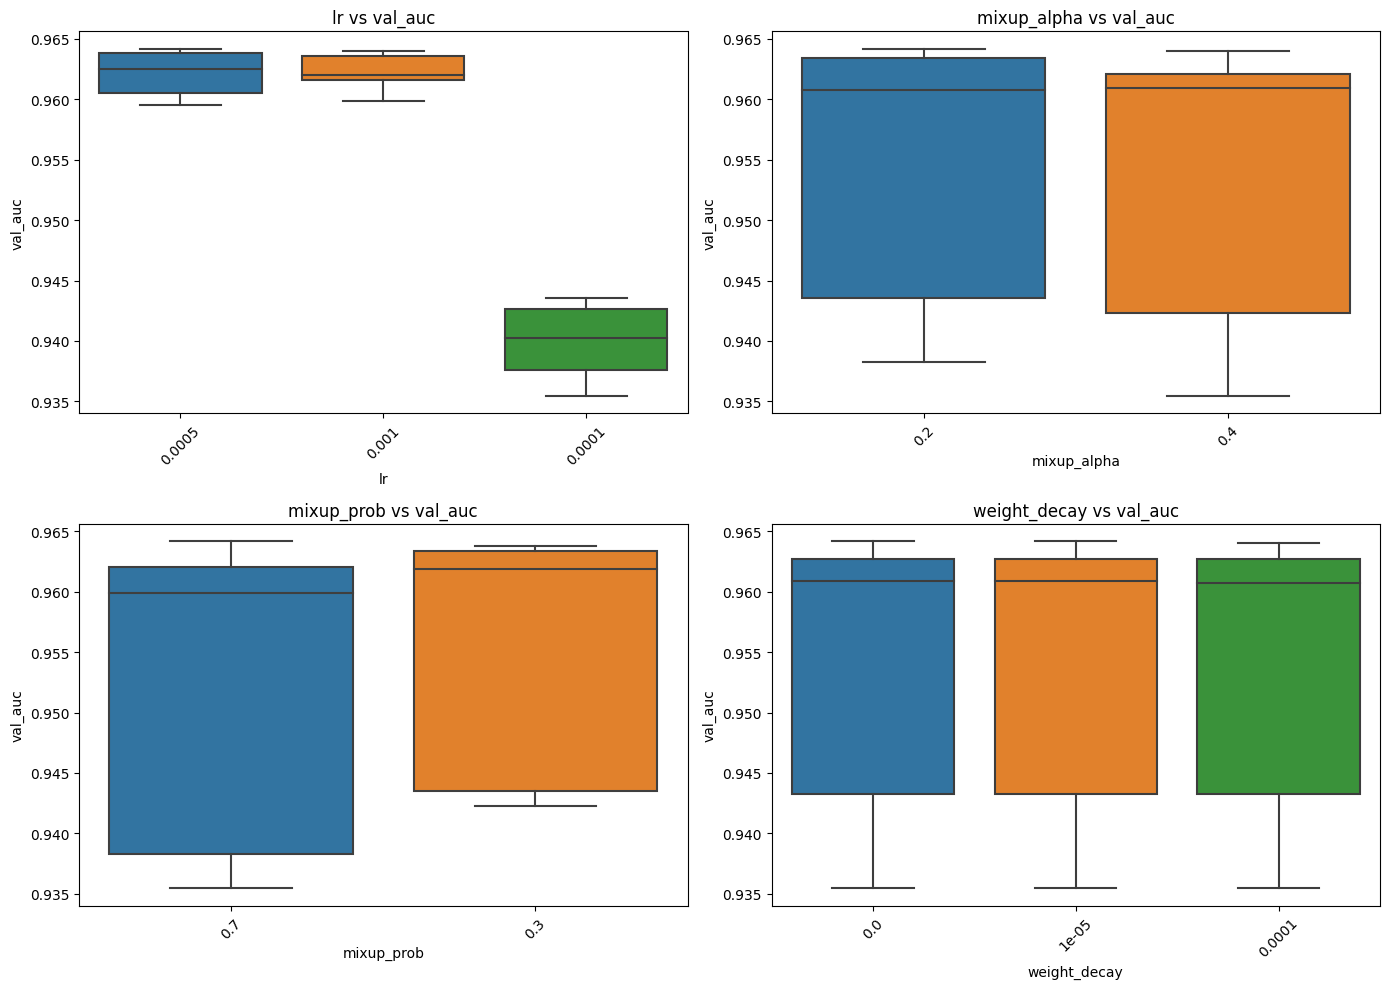

In [9]:
def plot_hyperparam_vs_val_auc(df):
    plt.figure(figsize=(14, 10))

    for i, param in enumerate(['lr', 'mixup_alpha', 'mixup_prob', 'weight_decay']):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x=param, y='val_auc', data=df)
        plt.title(f'{param} vs val_auc')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_hyperparam_vs_val_auc(best_hypara_df)

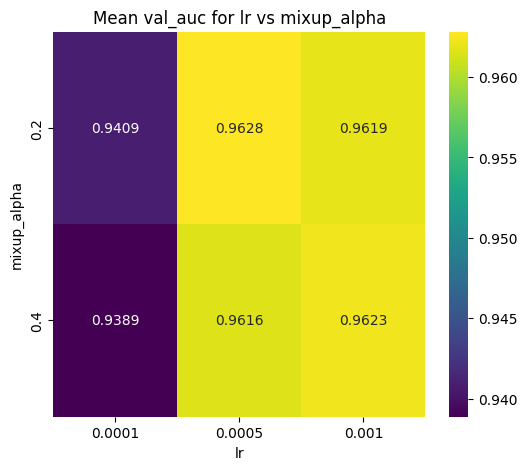

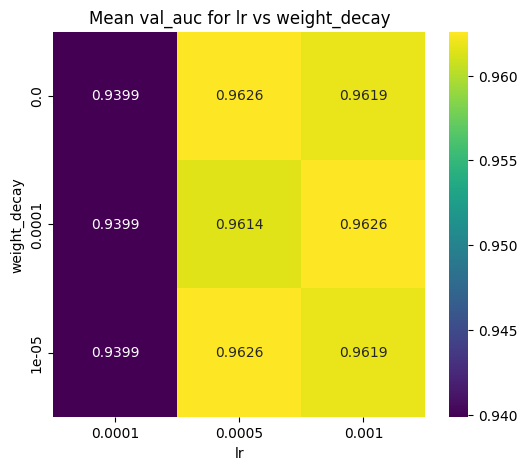

In [10]:
def plot_heatmap(df, x, y):
    pivot = df.pivot_table(values="val_auc", index=y, columns=x, aggfunc="mean")
    plt.figure(figsize=(6, 5))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
    plt.title(f"Mean val_auc for {x} vs {y}")
    plt.show()

# 例: learning rate × mixup_alpha
plot_heatmap(best_hypara_df, x='lr', y='mixup_alpha')
plot_heatmap(best_hypara_df, x='lr', y='weight_decay')